# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_42523/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_42523/1200496628.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


#### Get data in pcl format and print all columns names

In [2]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodels_results.pcl']
# pclFiles = ['./smodels_results_slha_gchi_001.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900026', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'Outpu

In [3]:
# create dataframe for combined data with necessary info
dataCombined = dataDF.to_dict('series')
dataCombined = dataCombined['CombinedRes'][~dataCombined['CombinedRes'].isna()]

In [4]:
dfs1 = []
initialDF = dataDF[~dataDF['CombinedRes'].isna()]
for i, l in enumerate(dataCombined):
    df_row = l[0]
    df_row['filename'] = initialDF['filename'].iloc[i]
    df_row['mass.9900032'] = initialDF['mass.9900032'].iloc[i]
    df_row['mass.9000006'] = initialDF['mass.9000006'].iloc[i]
    df_row['extpar.1'] = initialDF['extpar.1'].iloc[i]
    df_row['extpar.2'] = initialDF['extpar.2'].iloc[i]
    df_row['extpar.3'] = initialDF['extpar.3'].iloc[i]
    dfs1.append(df_row)
# dataDF_combined = pd.concat(dfs1, ignore_index=True)

In [5]:
dataDF_combined = pd.DataFrame(dfs1)
dataDF = dataDF.drop(columns=['CombinedRes'])

In [7]:
dataDF_combined.columns

Index(['AnalysisID', 'r', 'r_expected', 'nll', 'nll_min', 'nll_SM', 'filename',
       'mass.9900032', 'mass.9000006', 'extpar.1', 'extpar.2', 'extpar.3'],
      dtype='object')

In [8]:
dataDF_combined =  dataDF_combined.rename(columns={'r': 'ExptRes.result.r', 'r_expected': 'ExptRes.result.r_expected', 
                                                   'nll': 'ExptRes.result.nll', 'nll_min': 'ExptRes.result.nll_min', 
                                                   'nll_SM': 'ExptRes.result.nll_SM', 'AnalysisID': 'ExptRes.result.AnalysisID'})

#### Set r = 0 for points with no results 

In [9]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [10]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [11]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 21000
Total excluded (LHC) = 9780
Total allowed = 11220



### Get all analyses in one column

In [12]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c and not 'weights' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID', 'ExptRes.result6.AnalysisID', 'ExptRes.result7.AnalysisID', 'ExptRes.result8.AnalysisID']


In [13]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [14]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [15]:
txnames

['TRV1', 'TRS1', 'TRV1jj', 'TRV1bb', 'TRV1qq', 'TRV1tt']

In [16]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [17]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [18]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

,ExptRes.result.AnalysisID,ExptRes.result.TxNames,ExptRes.result.r
0,ATLAS-SUSY-2018-22-multibin,[TRV1],46.542400
1,ATLAS-EXOT-2018-06,[TRV1],39.504960
2,CMS-EXO-20-004,[TRV1],34.450300
3,ATLAS-SUSY-2018-22,[TRV1],16.672780
4,ATLAS-SUSY-2018-22-multibin,[TRV1],33.645760
...,...,...,...
147906,CMS-EXO-20-004,[TRS1],0.000003
147907,CMS-EXO-20-004,[TRS1],0.000003
147908,CMS-EXO-20-004,[TRS1],0.000002
147909,CMS-EXO-20-004,[TRS1],0.000002


In [21]:
newDF = pd.concat([newDF, dataDF_combined], ignore_index=True)

In [23]:
# filter couplings
gq = 0.1
gchi = 0.6
sina = 0.25

newDF = newDF[(newDF['extpar.1'] == gchi) & (newDF['extpar.2'] == gq) & (newDF['extpar.3'] == sina)]

In [24]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

In [25]:
newDF['ExptRes.result.AnalysisID'].unique()

array(['ATLAS-SUSY-2018-22-multibin', 'ATLAS-EXOT-2018-06',
       'CMS-EXO-20-004', 'ATLAS-SUSY-2018-22', 'CMS-EXO-16-057',
       'ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-12-059',
       'ATLAS-EXOT-2018-48', 'CMS-EXO-19-012', 'CMS-EXO-20-008',
       'ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004'], dtype=object)

In [26]:
dijetAnas = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-12-059', 'ATLAS-EXOT-2018-48', 'CMS-EXO-19-012', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']
monojetAnas = ['CMS-EXO-20-004', 'ATLAS-SUSY-2018-22', 'ATLAS-EXOT-2018-06']

#### Create legend for plots for excluded points

In [27]:
colors = sns.color_palette("Set1",len(newDF['ExptRes.result.AnalysisID'].unique()))


In [28]:
colorDict = {}

for i, l in enumerate(newDF['ExptRes.result.AnalysisID'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [29]:
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=ana)
    legend.append(l)

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

In [30]:
newDF['extpar.2'].unique()

array([0.1])

In [31]:
newDF['extpar.1'].unique()

array([0.6])

In [32]:
data = newDF.sort_values('filename')

In [36]:
dijet = newDF[newDF['ExptRes.result.AnalysisID'].isin(dijetAnas)]
monojet = newDF[newDF['ExptRes.result.AnalysisID'].isin(['ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004'])]

In [37]:
# monojet = monojet.sort_values(['filename', 'ExptRes.result.r_expected']).drop_duplicates(['filename'], keep='last')
dijet = dijet.sort_values(['filename', 'ExptRes.result.r']).drop_duplicates(['filename'], keep='last')

In [38]:
monojet = monojet.sort_values(['filename', 'ExptRes.result.r']).drop_duplicates(['filename'], keep='last')

In [39]:
mCols = ['filename']
keys = list(monojet[mCols].columns.values)
i1 = dijet.set_index(keys).index
i2 = monojet.set_index(keys).index
dijet = dijet[i1.isin(i2)]
monojet = monojet[i2.isin(i1)]
print(len(monojet),len(dijet))

2850 2850


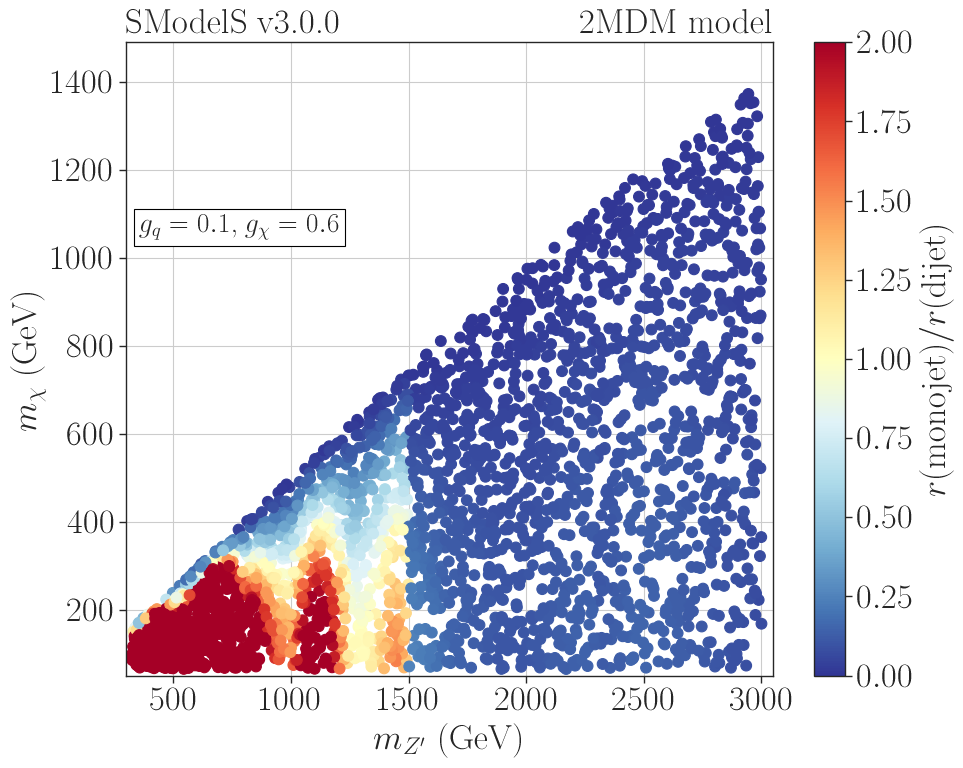

In [59]:
cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))


x = monojet['mass.9900032']
y = dijet['mass.9000006']
GM = np.array(dijet['width.9900032']/dijet['mass.9900032'])
c = np.array(monojet['ExptRes.result.r'])/np.array(dijet['ExptRes.result.r'])
# c = GM
# x = data_monoj['mass.9900032']
# y = data_monoj['mass.9000006']
# c = np.array(data_monoj['ExptRes.result.r'])/np.array(data_dij['ExptRes.result.r'])
sc = plt.scatter(x,y,c=c,s=60, cmap=cm, vmin=0., vmax=2.)
# sc = plt.scatter(x,y,c=c,s=60, cmap=cm)

    

cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=25)
cb.set_label(label=r'$r$(monojet)$/r$(dijet)',size=25)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.7,r'$g_{q} = %1.1f$, $g_{\chi} = %1.1f$' % (gq, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
plt.xlim(300, 3050)
plt.ylim(50, 1490)

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.grid()
# plt.legend()
plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_ratio_dij_monoj_c1.png')
plt.show()


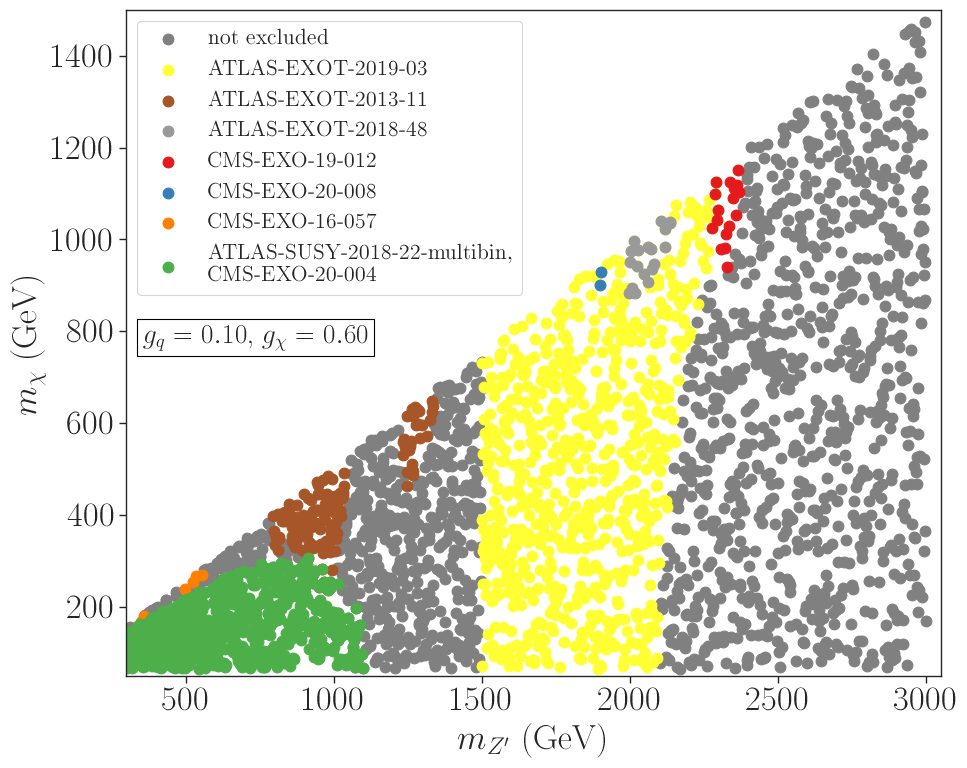

In [58]:
cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

gq = 0.1
gchi = 0.6

dataAll = dataDF[(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gq)&(dataDF['ExptRes.result0.r']<1.0)]
x = dataAll['mass.9900032'].dropna()
y = dataAll['mass.9000006'].dropna()
# c = dataAll['ExptRes.result0.r'].dropna()
scAll = plt.scatter(x,y,s=60, color='gray', label='not excluded')
# cb = plt.colorbar(scAll)
# cb.ax.tick_params(labelsize=25)
# cb.set_label(label=r'$r$',size=25)

anas = dijetAnas + ['ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004']
for label in anas:
    data = newDF.sort_values(['filename', 'ExptRes.result.r'])
    data = data[(data['extpar.1']==gchi)&(data['extpar.2']==gq)&(data['ExptRes.result.r']>=1.0)]
    data = data[data['ExptRes.result.AnalysisID']==label]
#     print(label,len(data))
    
    x = data['mass.9900032'].dropna()
    y = data['mass.9000006'].dropna()
    c = data['ExptRes.result.r'].dropna()
    if len(data) == 0: continue
    if label == 'ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004':
        sc = plt.scatter(x,y,s=60, color=colorDict[label], label='ATLAS-SUSY-2018-22-multibin,'+'\n'+'CMS-EXO-20-004')
    else:
        sc = plt.scatter(x,y,s=60, color=colorDict[label], label=label)


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gq, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
plt.xlim(300, 3050)
plt.ylim(50, 1500)

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_NWA.png')
plt.show()

In [41]:
colorDict2 = {}
colorDict2['$E_{T}^{miss} + j$'] = 'magenta'
colorDict2['diquark resonance'] = 'cyan'

In [42]:
legend2 = []
for ana, color in colorDict2.items():
    l = mpatches.Patch(color=color, label=ana)
    legend2.append(l)

ATLAS-EXOT-2019-03
ATLAS-EXOT-2013-11
CMS-EXO-19-012


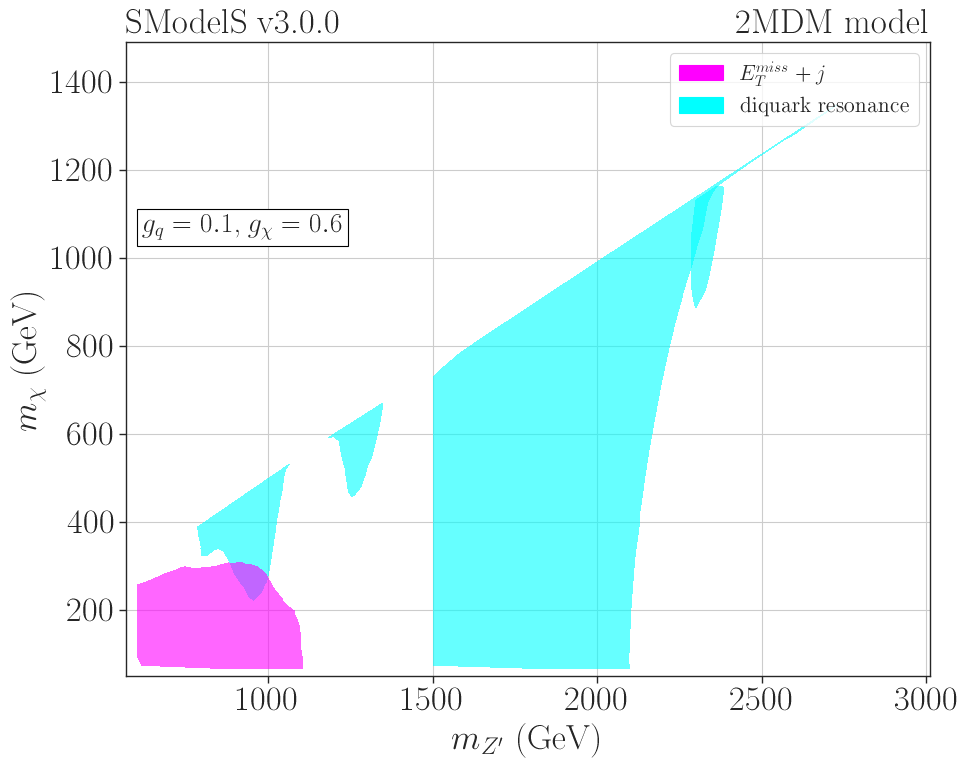

In [45]:
# plot with exclusion areas

cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

# x = monojet['mass.9900032']
# y = monojet['mass.9000006']
# c = np.array(monojet['r'])/np.array(dijet['ExptRes.result.r'])
# sc = plt.scatter(x,y,c=c,s=60, cmap=cm, vmin=0., vmax=2.)

# cb = plt.colorbar(sc)
# cb.ax.tick_params(labelsize=25)
# cb.set_label(label=r'$r$(monojet)$/r$(dijet)',size=25)

for label in excluded['ExptRes.result.AnalysisID'].unique():
    # if 'CMS-EXO-16-057'  in label : continue
    # if 'ATLAS-EXOT-2019-03' in label: continue
    # if 'ATLAS-EXOT-2018-48' in label: continue
    # if 'CMS-EXO-20-008' in label: continue
    # if 'ATLAS-EXOT-2013-11' in label: continue
    # if 'CMS-EXO-19-012' in label: continue
    # print(label)
    data = dijet[(dijet['ExptRes.result.AnalysisID']==label)]
    rData = data['ExptRes.result.r']
    if len(rData) == 0: continue
    print(label)
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    # cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label], linewidths=2.0, extend='min')
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.6, colors=colorDict2['diquark resonance'])

data = monojet
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]
# cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict['CMS-EXO-20-004 (TRV1) (13 TeV)'], linewidths=2.0, extend='max')
plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.6, colors=colorDict2['$E_{T}^{miss} + j$'])

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.7,r'$g_{q} = %1.1f$, $g_{\chi} = %1.1f$' % (gq, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

# plt.vlines(1500, 50, 750, color=colorDict['ATLAS-EXOT-2019-03 (TRV1jj) (13 TeV)'], linewidth=2.0)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
plt.xlim(570, 3010)
plt.ylim(50, 1490)

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.grid()

plt.legend(handles=[legend2[0], legend2[1]])

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_ratio_dij_monoj_curves.png')
plt.show()


In [33]:
colorDict

{'ATLAS-SUSY-2018-22-multibin': array([[0.89411765, 0.10196078, 0.10980392]]),
 'ATLAS-EXOT-2018-06': array([[0.21568627, 0.49411765, 0.72156863]]),
 'CMS-EXO-20-004': array([[0.30196078, 0.68627451, 0.29019608]]),
 'ATLAS-SUSY-2018-22': array([[0.59607843, 0.30588235, 0.63921569]]),
 'ATLAS-EXOT-2019-03': array([[1.        , 0.49803922, 0.        ]]),
 'CMS-EXO-20-008': array([[1. , 1. , 0.2]]),
 'CMS-EXO-16-057': array([[0.65098039, 0.3372549 , 0.15686275]]),
 'ATLAS-EXOT-2018-48': array([[0.96862745, 0.50588235, 0.74901961]]),
 'ATLAS-EXOT-2013-11': array([[0.6, 0.6, 0.6]]),
 'CMS-EXO-19-012': array([[0.89411765, 0.10196078, 0.10980392]])}

ATLAS-EXOT-2019-03
ATLAS-EXOT-2013-11
CMS-EXO-19-012


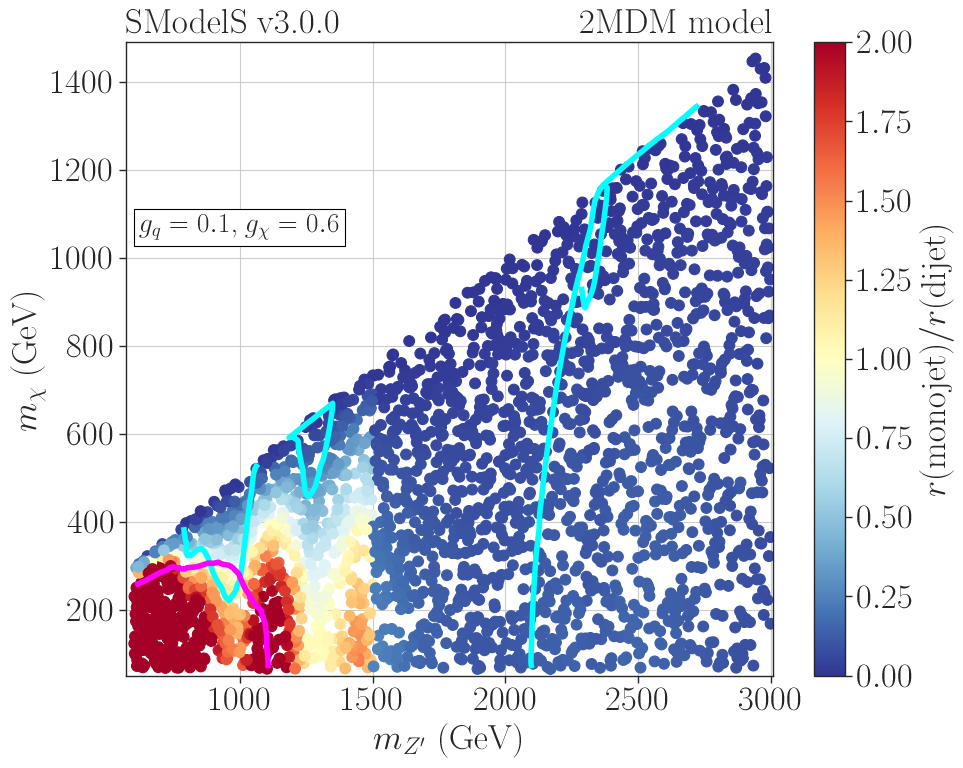

In [49]:
# plot with exclusion areas

cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

x = monojet['mass.9900032']
y = monojet['mass.9000006']
c = np.array(monojet['r'])/np.array(dijet['ExptRes.result.r'])
sc = plt.scatter(x,y,c=c,s=60, cmap=cm, vmin=0., vmax=2.)

cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=25)
cb.set_label(label=r'$r$(monojet)$/r$(dijet)',size=25)

for label in excluded['ExptRes.result.AnalysisID'].unique():
    # if 'CMS-EXO-16-057'  in label : continue
    # if 'ATLAS-EXOT-2019-03' in label: continue
    # if 'ATLAS-EXOT-2018-48' in label: continue
    # if 'CMS-EXO-20-008' in label: continue
    # if 'ATLAS-EXOT-2013-11' in label: continue
    # if 'CMS-EXO-19-012' in label: continue
    # print(label)
    data = dijet[(dijet['ExptRes.result.AnalysisID']==label)]
    rData = data['ExptRes.result.r']
    if len(rData) == 0: continue
    print(label)
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict2['diquark resonance'], linewidths=4.0, extend='min')
    # plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.6, colors='black')

data = monojet
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]
cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict2['$E_{T}^{miss} + j$'], linewidths=4.0, extend='max')
# plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.6, colors='black')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.7,r'$g_{q} = %1.1f$, $g_{\chi} = %1.1f$' % (gq, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

# plt.vlines(1500, 50, 750, color=colorDict['ATLAS-EXOT-2019-03 (TRV1jj) (13 TeV)'], linewidth=2.0)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
plt.xlim(570, 3010)
plt.ylim(50, 1490)

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.grid()
# plt.legend()
plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_ratio_dij_monoj_lines.png')
plt.show()


ATLAS-EXOT-2019-03
ATLAS-EXOT-2013-11
CMS-EXO-19-012


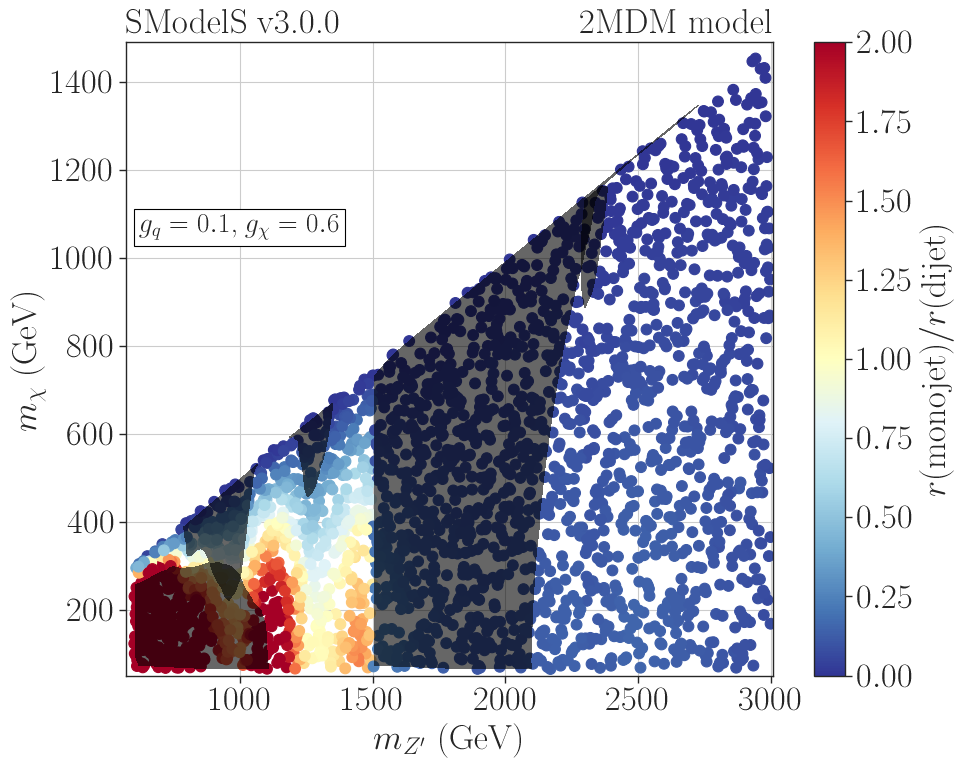

In [ ]:
# plot with exclusion areas

cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

x = monojet['mass.9900032']
y = monojet['mass.9000006']
c = np.array(monojet['r'])/np.array(dijet['ExptRes.result.r'])
sc = plt.scatter(x,y,c=c,s=60, cmap=cm, vmin=0., vmax=2.)

cb = plt.colorbar(sc)
cb.ax.tick_params(labelsize=25)
cb.set_label(label=r'$r$(monojet)$/r$(dijet)',size=25)

for label in excluded['ExptRes.result.AnalysisID'].unique():
    # if 'CMS-EXO-16-057'  in label : continue
    # if 'ATLAS-EXOT-2019-03' in label: continue
    # if 'ATLAS-EXOT-2018-48' in label: continue
    # if 'CMS-EXO-20-008' in label: continue
    # if 'ATLAS-EXOT-2013-11' in label: continue
    # if 'CMS-EXO-19-012' in label: continue
    # print(label)
    data = dijet[(dijet['ExptRes.result.AnalysisID']==label)]
    rData = data['ExptRes.result.r']
    if len(rData) == 0: continue
    print(label)
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    # cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict[label], linewidths=2.0, extend='min')
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.6, colors='black')

data = monojet
rData = data['ExptRes.result.r']
pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
pts = pts[~np.isnan(rPts)]
rPts = rPts[~np.isnan(rPts)]
# cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=colorDict['CMS-EXO-20-004 (TRV1) (13 TeV)'], linewidths=2.0, extend='max')
plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.6, colors='black')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.7,r'$g_{q} = %1.1f$, $g_{\chi} = %1.1f$' % (gq, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

# plt.vlines(1500, 50, 750, color=colorDict['ATLAS-EXOT-2019-03 (TRV1jj) (13 TeV)'], linewidth=2.0)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
plt.xlim(570, 3010)
plt.ylim(50, 1490)

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.grid()
# plt.legend()
plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_ratio_dij_monoj_shade.png')
plt.show()


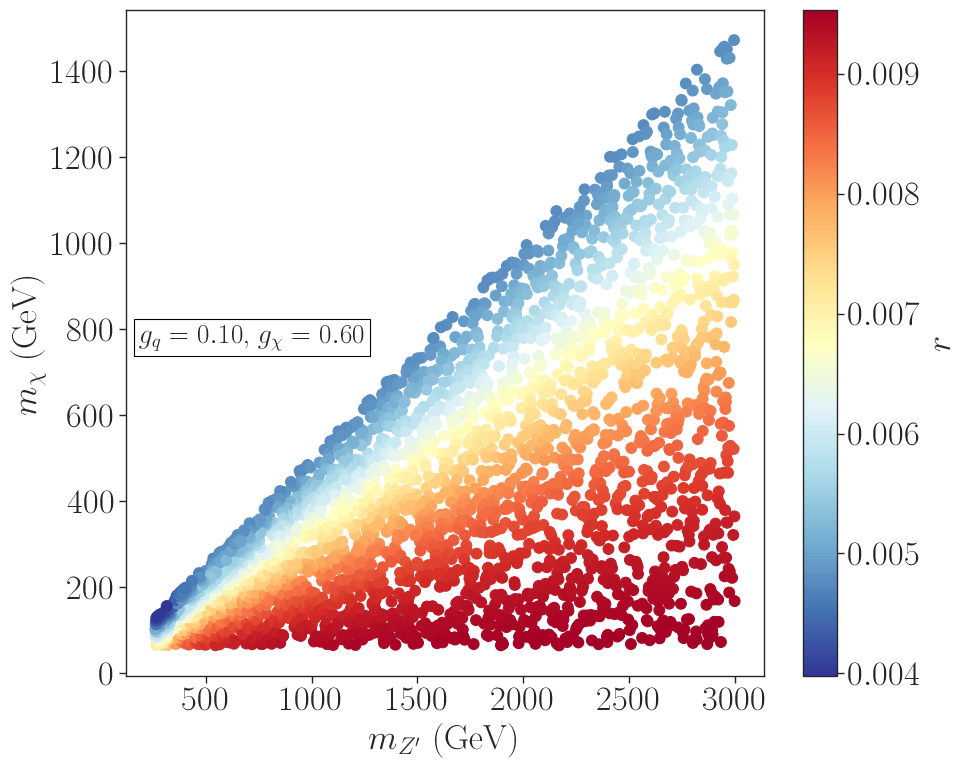

In [33]:
cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

gqv = 0.1
gchi = 0.6

dataAll = dataDF[(dataDF['extpar.1']==gchi)&(dataDF['extpar.2']==gqv)]

x = dataAll['mass.9900032'].dropna()
y = dataAll['mass.9000006'].dropna()

gamma = np.array(dataAll['width.9900032'].dropna())
ratioGM = np.array(dataAll['width.9900032'].dropna())/np.array(x)

c = ratioGM

scAll = plt.scatter(x,y,c=c,s=60, cmap=cm)
cb = plt.colorbar(scAll)
cb.ax.tick_params(labelsize=25)
cb.set_label(label=r'$r$',size=25)


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.tight_layout()
# plt.savefig('./figures/exclusions_2mdm_dijet_only.png')
plt.show()